In [1]:
#!pip install datasets
from datasets import load_dataset
dataset_train=load_dataset("yelp_review_full",split='train')
dataset_test=load_dataset("yelp_review_full",split='test')

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [2]:
import pandas as pd
new_train=pd.DataFrame(dataset_train)
new_test=pd.DataFrame(dataset_test)
new_train.head()
#Ho fatto un dataframe per ragioni di visualizzazione,poi non lo uso più, alla fine si potrà levare.
import string
#new_train['text'].replace(to_replace='\n', value='',inplace==True,regex=True)
new_train['text'] = new_train['text'].str.replace(r'\n', '', regex=True)
new_train['text'] = new_train['text'].str.replace(r'dr.', 'dr', regex=True)
new_test['text'] = new_test['text'].str.replace(r'\n', '', regex=True)

# split sentences
sentences_train = [new_train['text'].str.split(('[?!.]\s'))]
#sentences_test = [new_test['text'].str.split(('[?!.]\s'))] Lo faccio dopo quando testo modello

print(new_train[:2])
print(sentences_train[:2])


   label                                               text
0      4  dr goldberg offers everything i look for in a ...
1      1  Unfortunately, the frustration of being Dr. Go...
[0         [dr goldberg offers everything i look for in a...
1         [Unfortunately, the frustration of being Dr, G...
2         [Been going to Dr, Goldberg for over 10 years,...
3         [Got a letter in the mail last week that said ...
4         [I don't know what Dr, Goldberg was like befor...
                                ...                        
649995    [I had a sprinkler that was gushing.., pipe br...
649996    [Phone calls always go to voicemail and messag...
649997    [Looks like all of the good reviews have gone ...
649998    [I was able to once again rely on Yelp to prov...
649999    [I have been using this company for 11 months,...
Name: text, Length: 650000, dtype: object]


In [3]:
labels = new_train['label']

from collections import Counter

label_count = Counter(labels)
print(label_count)

#I rating vanno da 1 a 5, lui conta come 0-4, va aggiustato nel print

Counter({4: 130000, 1: 130000, 3: 130000, 0: 130000, 2: 130000})


In [4]:
from pandas.core.common import flatten
import re

sentences_train = list(flatten(sentences_train))
#sentences_train[:20]

#Da qui possiamo fare un word2vec

tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences_train]
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

['dr', 'goldberg', 'offers', 'everything', 'i', 'look', 'for', 'in', 'a', 'general', 'practitioner']
['he', 's', 'nice', 'and', 'easy', 'to', 'talk', 'to', 'without', 'being', 'patronizing', 'he', 's', 'always', 'on', 'time', 'in', 'seeing', 'his', 'patients', 'he', 's', 'affiliated', 'with', 'a', 'top', 'notch', 'hospital', 'nyu', 'which', 'my', 'parents', 'have', 'explained', 'to', 'me', 'is', 'very', 'important', 'in', 'case', 'something', 'happens', 'and', 'you', 'need', 'surgery', 'and', 'you', 'can', 'get', 'referrals', 'to', 'see', 'specialists', 'without', 'having', 'to', 'see', 'him', 'first']
['really', 'what', 'more', 'do', 'you', 'need']
['i', 'm', 'sitting', 'here', 'trying', 'to', 'think', 'of', 'any', 'complaints', 'i', 'have', 'about', 'him', 'but', 'i', 'm', 'really', 'drwing', 'a', 'blank']
['unfortunately', 'the', 'frustration', 'of', 'being', 'dr']
['goldberg', 's', 'patient', 'is', 'a', 'repeat', 'of', 'the', 'experience', 'i', 've', 'had', 'with', 'so', 'many', 'o

In [4]:
from gensim.models.word2vec import Word2Vec
#import Cython

model = Word2Vec(tokenized_sentences, vector_size=100, min_count=10, window=50,workers=16)
len(model.wv)
#vector_size è dimensione embedding (e neuroni in unico hidden layer della rete che traina il modello)
#min_count=n ho dataset sufficientemente grande, ignoro parole in training non ripetute per almeno n volte
#Workers per parallelizzare, ma serve aver installato Cython
#Nel modello trainato a esercitazione impara 22069 termini, con gli stessi parametri e questo dataset faccio 71741 (Tempo di training qualche minuto)
#Param(100,10,50)== imparo 50660 termini. (Tempo di training più lungo rispetto a prima)
#Con i workers settati a 4 non un grande miglioramento, a 16 neanche)



50660

In [5]:
from gensim.models import KeyedVectors
model.save('word2vecmodel.kv')

In [6]:
#model=KeyedVectors.load('word2vecmodel.kv') Avevo salvato il modello per non dover ritrainare di nuovo

In [7]:
term='dog'

print(model.wv.most_similar(term))

''' Con doctor :[('doc', 0.8475900292396545), ('nurse', 0.8461596369743347), ('physician', 0.8378857970237732), 
('dentist', 0.8168233036994934), ('vet', 0.8085538148880005), ('specialist', 0.7914314270019531),
('doctors', 0.7844577431678772), ('surgery', 0.7513441443443298), ('surgeon', 0.7347343564033508), 
('pediatrician', 0.7288122773170471)]'''

[('dogs', 0.8786824345588684), ('cat', 0.7320694327354431), ('puppy', 0.7157762050628662), ('pup', 0.7020530104637146), ('pups', 0.6732111573219299), ('pet', 0.6585353016853333), ('hotdog', 0.6530022025108337), ('animal', 0.6450294256210327), ('chihuahua', 0.6327224373817444), ('maltese', 0.6310962438583374)]


" Con doctor :[('doc', 0.8475900292396545), ('nurse', 0.8461596369743347), ('physician', 0.8378857970237732), \n('dentist', 0.8168233036994934), ('vet', 0.8085538148880005), ('specialist', 0.7914314270019531),\n('doctors', 0.7844577431678772), ('surgery', 0.7513441443443298), ('surgeon', 0.7347343564033508), \n('pediatrician', 0.7288122773170471)]"

In [8]:
import gensim.downloader as api

model_wiki = api.load("glove-wiki-gigaword-300")
print(len(model_wiki))
print(model_wiki.most_similar(term))
''' Con doctor: [('physician', 0.704085111618042), ('doctors', 0.6507135033607483), ('medical', 0.5991251468658447), 
('dr.', 0.5985949039459229), ('surgeon', 0.5897458791732788), ('nurse', 0.5859817266464233), 
('hospital', 0.568318784236908), ('dentist', 0.5561408996582031), ('patient', 0.5560954809188843),
('pharmacist', 0.533785879611969)] 400000'''

#Con termini relativi a dottore ottengo migliori similarità nem mio word2vec, con termine a caso risultati più vicini
#al model_wiki

[==================================================] 100.0% 376.1/376.1MB downloaded
400000
[('dogs', 0.7888557314872742), ('cat', 0.6816746592521667), ('pet', 0.6291598081588745), ('puppy', 0.593606173992157), ('hound', 0.5468214750289917), ('horse', 0.5369751453399658), ('animal', 0.5316445827484131), ('cats', 0.5080744028091431), ('canine', 0.5038436055183411), ('pets', 0.5019966959953308)]


" Con doctor: [('physician', 0.704085111618042), ('doctors', 0.6507135033607483), ('medical', 0.5991251468658447), \n('dr.', 0.5985949039459229), ('surgeon', 0.5897458791732788), ('nurse', 0.5859817266464233), \n('hospital', 0.568318784236908), ('dentist', 0.5561408996582031), ('patient', 0.5560954809188843),\n('pharmacist', 0.533785879611969)] 400000"

In [11]:
#Ora proviamo a fare prediction delle labels con embedding
from sklearn.linear_model import LogisticRegression
import numpy as np

regex = '[' + string.punctuation + ']'
train_x= new_train['text']
train_y=[new_train['label']]

def vectorize(docs, embedding_model=model.wv, useSum=True):
    vectors = np.zeros((len(docs),100))
    for i in range(len(docs)):
    
        tokens = re.sub(regex, '', docs[i].lower()).split()
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        if (len(embeddings) > 0):
            if (useSum):
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

train_x_vector = vectorize(train_x)
#così ok
#Con tokenized sentences perdi dimensioni effettive

In [12]:
train_y=new_train['label']
print(len(train_x_vector))
print(len(train_y))

650000
650000


In [13]:
test_x=new_test['text']
test_x_vector=vectorize(test_x)

In [14]:
lr_model = LogisticRegression(max_iter=5000).fit(train_x_vector, train_y)
print(lr_model)

#Test
test_y=new_test['label']

pred_y = lr_model.predict(test_x_vector)
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(test_y, pred_y)}')


LogisticRegression(max_iter=5000)
Accuracy: 0.5445


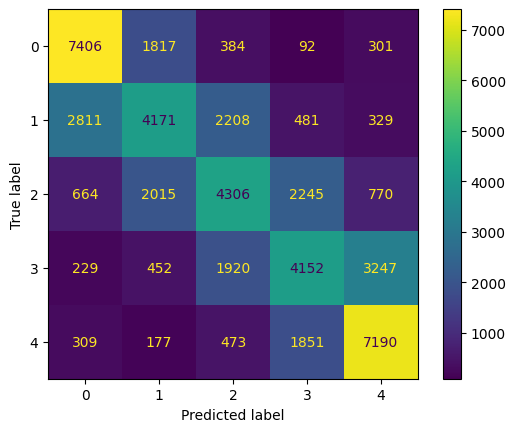

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lr_model, test_x_vector, test_y, values_format='d')
plt.show()
#Fino a qua è andato tutto liscio, però con regressione logistica la classificazione è pessima